In [1]:
library(dplyr)
library(ggplot2)
library(reshape2)
library(beepr)
library(wesanderson)
options(repr.plot.width=16, repr.plot.height=8) #make all the plots larger


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘reshape2’ was built under R version 4.0.5”


# Import Mutation Data

In [11]:
mutation_data_raw <- read.csv("../Reference_Files/Mutation_Analysis/adaptation.gene_sets.filtered.tsv", header = TRUE, sep = "\t")
mutation_data_raw$mutant_sample <- substr(mutation_data_raw$mutant_sample, 3, 5)
unique(mutation_data_raw$mutant_sample)
mutation_data_raw <- mutation_data_raw[mutation_data_raw$mutant_sample == "S29" | mutation_data_raw$mutant_sample == "S23",]
head(mutation_data_raw)
dim(mutation_data_raw)
length(unique(mutation_data_raw$Gene.primaryIdentifier))
mutation_data_raw[duplicated(mutation_data_raw$Gene.primaryIdentifier),]

[1] "S26" "S30" "S31" "S21" "S29" "S25" "2"   "S27" "S24" "S23" "1"

,Gene.primaryIdentifier,chromosome,position,mutation,type,mutant_sample,genic,exonic,intronic,intergenic,⋯,FPKM,Nonsyn_V_Syn,X,nessID,FPKM_per_transcript,cluster,expressed,expressed_genes,perrineau,perrineau_genes
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<int>,<chr>
7,Cre01.g016350,chromosome_1,2758843,C>T,SNP,S29,1,1,0,0,⋯,16.55518366,n/a,276,26904181,16.555183,non-cluster,1,['26904181'],0,NA
16,Cre01.g051950,chromosome_1,7223914,G>A,SNP,S29,1,0,1,0,⋯,.,n/a,264,26904006,15.804940,non-cluster,1,['26904006'],0,NA
23,Cre10.g440600,chromosome_10,2974075,C>CA,indel,S29,1,1,0,0,⋯,0.582091988,n/a,296,26905366,0.582092,non-cluster,0,NA,0,NA
24,Cre10.g440600,chromosome_10,2974077,C>CACACACAGCAGCTGGAG,indel,S29,1,1,0,0,⋯,0.582091988,n/a,296,26905366,0.582092,cluster,0,NA,0,NA
35,Cre12.g511750,chromosome_12,1845232,C>A,SNP,S29,1,1,0,0,⋯,9.107483053,nonsynonymous,314,26907398,9.107483,non-cluster,1,['26907398'],1,['Cre12.g511750']
50,Cre12.g554750,chromosome_12,7642263,G>A,SNP,S23,1,1,0,0,⋯,50.02293245,synonymous,316,26907414,50.022934,non-cluster,1,['26907414'],1,['Cre12.g554750']


[1] 23 30

[1] 17

,Gene.primaryIdentifier,chromosome,position,mutation,type,mutant_sample,genic,exonic,intronic,intergenic,⋯,FPKM,Nonsyn_V_Syn,X,nessID,FPKM_per_transcript,cluster,expressed,expressed_genes,perrineau,perrineau_genes
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,⋯,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<int>,<chr>
24,Cre10.g440600,chromosome_10,2974077,C>CACACACAGCAGCTGGAG,indel,S29,1,1,0,0,⋯,0.582091988,n/a,296,26905366,0.582092,cluster,0,NA,0,NA
121,,chromosome_2,7696095,A>AGGCTGTGGTG,indel,S29,0,0,0,1,⋯,.,n/a,NA,NA,NA,non-cluster,0,NA,0,NA
146,Cre05.g245700,chromosome_5,1145934,C>T,SNP,S29,1,1,0,0,⋯,9.842150935,n/a,123,26897974,9.842151,cluster,1,['26897974'],1,['Cre05.g245700']
147,Cre05.g245700,chromosome_5,1145935,A>C,SNP,S29,1,1,0,0,⋯,9.842150935,n/a,123,26897974,9.842151,cluster,1,['26897974'],1,['Cre05.g245700']
190,Cre06.g292400,chromosome_6,6423838,G>GGGGCACTCC,indel,S29,1,0,1,0,⋯,.,n/a,37,26893158,6.366075,non-cluster,1,['26893158'],0,NA
226,,chromosome_9,3485483,G>T,SNP,S23,0,0,0,1,⋯,.,n/a,NA,NA,NA,non-cluster,0,NA,0,NA


# DEG Data

## S0 -> S36 Condition

In [12]:
S0_S36_DEGs <- read.csv("../DE_Analysis/S0_S36_DEGs.csv", header = TRUE)
names(S0_S36_DEGs)[names(S0_S36_DEGs) == 'X'] <- "Genes"
head(S0_S36_DEGs)
dim(S0_S36_DEGs)
S0_S36_DEGs_names <- S0_S36_DEGs$Genes

,Genes,LFC,padj,DE
,<chr>,<dbl>,<dbl>,<lgl>
1,ADF43161.1,-5.079540,2.540306e-12,TRUE
2,ADF43181.1,2.072156,2.505219e-15,TRUE
3,ADF43182.1,3.166958,1.519643e-08,TRUE
4,ADF43183.1,2.146753,7.903401e-05,TRUE
5,ADF43190.1,-2.191439,1.190823e-22,TRUE
6,ADF43193.1,-3.210325,2.484548e-14,TRUE


[1] 1536    4

# Distance Between mutations and DEGs Gene Edges

## Find the location of the DEGs and Genes

In [16]:
#Import the data
gene_positions <- read.csv("../Reference_Files/Mutation_Analysis/final.strict.GFF3.gz", header = FALSE, sep = "\t")[, c(1, 3:5, 10)]
colnames(gene_positions) <- c("Chromosome", "Classification", "Start", "End", "Name")

#Remove everything but genes
gene_positions <- gene_positions[grepl("gene", gene_positions$Classification),] #Still includes cp and mt genes
gene_positions <- gene_positions[grepl("_\\d+", gene_positions$Chromosome),] #get just chromosomes
#unique(gene_positions$Classification)

#Remove the word "chromosome" and "scaffold" to just get the number
gene_positions$Chromosome <- gsub("chromosome_", "", gene_positions$Chromosome)
gene_positions$Chromosome <- gsub("scaffold_", "", gene_positions$Chromosome)
gene_positions$Chromosome <- as.numeric(gene_positions$Chromosome)
# unique(gene_positions$Chromosome)

#Remove the word "Name=" to just get the gene name only 
gene_positions$Name <- gsub("Name=", "", as.character(gene_positions$Name))
#unique(gene_positions$Name)

gene_positions$Start <- as.numeric(gene_positions$Start)
#sum(is.na(gene_positions$Start))
gene_positions$End <- as.numeric(gene_positions$End)

head(gene_positions)
dim(gene_positions)

,Chromosome,Classification,Start,End,Name
,<dbl>,<chr>,<dbl>,<dbl>,<chr>
1,1,gene,18766,20237,g2
9,1,gene,20356,23957,g3
31,1,gene,24026,30617,Cre01.g000050
44,1,gene,30776,41037,Cre01.g000100
74,1,gene,41896,46547,Cre01.g000150
89,1,gene,46553,51525,Cre01.g000200


[1] 18773     5

In [17]:
#How many DEGs were there? Use this in case want to change the list of DEGs can do that without changing all the code
DEG_name_list<- S0_S36_DEGs_names
length(DEG_name_list)

#Get the positions for the DEGs
DEG_positions <- gene_positions[gene_positions$Name %in% DEG_name_list,]
# dim(DEG_positions)
#head(DEG_positions)

separator = 1000000000
DEG_positions <- DEG_positions %>%
    mutate(Start = Start + (separator * as.numeric(Chromosome))) %>%
    mutate(End = End + (separator * as.numeric(Chromosome))) %>%
    select(Name, Start, End) %>%
    melt(id.vars = "Name", variable.name = "edge", value.name = "gene_position")

names(DEG_positions)[names(DEG_positions) == 'Name'] <- "genes"
dim(DEG_positions)
head(DEG_positions)

#Missing genes are the ones that are in the chloroplasts or ribosomes
length(DEG_name_list[!(DEG_name_list %in% DEG_positions$genes)])
DEG_name_list[!(DEG_name_list %in% DEG_positions$genes)]

size = dim(DEG_positions)[1]/2 #since we doubled the list because of the melting but there are still only 1484 DEGs
size

[1] 1536

[1] 3030    3

,genes,edge,gene_position
,<chr>,<fct>,<dbl>
1,g3,Start,1000020356
2,Cre01.g000150,Start,1000041896
3,g28,Start,1000166882
4,Cre01.g002650,Start,1000456376
5,Cre01.g003000,Start,1000533296
6,Cre01.g003200,Start,1000559606


[1] 21

[1] "ADF43161.1" "ADF43181.1" "ADF43182.1" "ADF43183.1" "ADF43190.1"
 [6] "ADF43193.1" "ADF43199.1" "ChreCp032"  "ChreCp035"  "ChreCp036" 
[11] "ChreCp037"  "ChreCp039"  "ChreCp048"  "ChreCp052"  "ChreCp056" 
[16] "ChreCp059"  "ChreCp062"  "ChreCp064"  "ChreCp066"  "ChreCp069" 
[21] "ChrepMr16"

[1] 1515

## Get the location of the Mutations

In [18]:
mutation_positions <- mutation_data_raw[, c(1:3)]
mutation_positions$chromosome <- as.numeric(gsub("chromosome_", '', mutation_positions$chromosome))

mutation_positions <- mutation_positions%>%
    mutate(position = position + (separator * as.numeric(chromosome)))%>%
    select(Gene.primaryIdentifier, position)

colnames(mutation_positions) <- c("mutation", "mutation_position")
head(mutation_positions)
num_mutations = dim(mutation_positions)[1]
num_mutations 

,mutation,mutation_position
,<chr>,<dbl>
7,Cre01.g016350,1002758843
16,Cre01.g051950,1007223914
23,Cre10.g440600,10002974075
24,Cre10.g440600,10002974077
35,Cre12.g511750,12001845232
50,Cre12.g554750,12007642263


[1] 23

## Get the NULL Distribution

In [19]:
random_sampling_edges <- function(){
    #Randomly pick genes from the gff without replacement
    sampled_gene_names = sample(gene_positions$Name, size, replace = FALSE)
    sampled_gene_data <- gene_positions[gene_positions$Name %in% sampled_gene_names,]
    
    #Scale by chromosome
    sampled_gene_data <- sampled_gene_data %>%
        mutate(Start = Start + (separator * as.numeric(Chromosome))) %>%
        mutate(End = End + (separator * as.numeric(Chromosome))) %>%
        select(Name, Start, End)%>%
        melt(id.vars = "Name", variable.name = "edge", value.name = "gene_position")

    names(sampled_gene_data)[names(sampled_gene_data) == 'Name'] <- "genes"
    
    return(sampled_gene_data)
}

In [20]:
distance_from_mutations <- function(sampled_gene_data){
    #Find how far away they are from a given mutation
    #Repeat the sampled genes the same amount as the mutations
    sampled_gene_data <- sampled_gene_data %>% 
        slice(rep(1:n(), each = num_mutations)) %>% #repeat the sampled gene lists 23 times (number of mutations)
        cbind(mutations_repeated) %>% #bind the two together 
        mutate(distance = abs(gene_position - mutation_position))
    
    sampled_gene_data$distance <- ifelse(sampled_gene_data$genes == sampled_gene_data$mutation, 
                                    yes = 0, no = sampled_gene_data$distance)

    min_distance_mutation <- aggregate(distance ~ mutation_position, 
                                             data = sampled_gene_data, FUN = min)
    
    return(min_distance_mutation)
}

In [21]:
#Repeat the mutations the same amount as the genes
mutations_repeated <- data.frame(lapply(mutation_positions, rep, size))
sample_trials <- mutation_positions #make a dummy data frame with the right dimensions

for (i in 1:1000){
    min_distance_m <- distance_from_mutations(random_sampling_edges())
    
    #store each trial for the min distances for each mutation
    sample_trials <- merge(sample_trials, min_distance_m, by = "mutation_position", suffixes = c("", as.character(i)))
}

head(sample_trials)
dim(sample_trials)

,mutation_position,mutation,distance,distance2,distance3,distance4,distance5,distance6,distance7,distance8,⋯,distance991,distance992,distance993,distance994,distance995,distance996,distance997,distance998,distance999,distance1000
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1002758843,Cre01.g016350,86094,26690,13323,0,43032,64463,22820,62240,⋯,68404,59369,4549,0,30130,22820,0,10521,22820,2230
2,1007223914,Cre01.g051950,25684,0,23367,9675,2527,9675,0,25427,⋯,2122,58727,25684,2122,2527,2527,6194,16682,32977,16682
3,2007696095,,33760,18248,30,21928,2068,135618,13738,14058,⋯,37320,40799,755,14058,39978,103040,3268,2068,55550,32895
4,3005280766,g3802,36993,54260,12127,8026,21475,29810,64273,42626,⋯,5683,4677,4677,7733,5557,4677,21475,5683,42626,12127
5,5001145933,Cre05.g245700,45078,157156,28785,11573,30753,305,103958,53186,⋯,11573,25816,305,25816,0,30753,48223,45078,151597,217367
6,5001145934,Cre05.g245700,45077,157155,28786,11572,30752,304,103959,53185,⋯,11572,25817,304,25817,0,30752,48222,45077,151598,217368


[1]   23 1002

## Get the distance of DEGs to mutations

In [22]:
head(DEG_positions)

,genes,edge,gene_position
,<chr>,<fct>,<dbl>
1,g3,Start,1000020356
2,Cre01.g000150,Start,1000041896
3,g28,Start,1000166882
4,Cre01.g002650,Start,1000456376
5,Cre01.g003000,Start,1000533296
6,Cre01.g003200,Start,1000559606


In [23]:
min_distance_DEGs <- distance_from_mutations(DEG_positions)
head(min_distance_DEGs)

,mutation_position,distance
,<dbl>,<dbl>
1,1002758843,30130
2,1007223914,4252
3,2007696095,13738
4,3005280766,139971
5,5001145933,0
6,5001145934,0


## Mega Histogram

In [24]:
head(sample_trials)
dim(sample_trials)

,mutation_position,mutation,distance,distance2,distance3,distance4,distance5,distance6,distance7,distance8,⋯,distance991,distance992,distance993,distance994,distance995,distance996,distance997,distance998,distance999,distance1000
,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1002758843,Cre01.g016350,86094,26690,13323,0,43032,64463,22820,62240,⋯,68404,59369,4549,0,30130,22820,0,10521,22820,2230
2,1007223914,Cre01.g051950,25684,0,23367,9675,2527,9675,0,25427,⋯,2122,58727,25684,2122,2527,2527,6194,16682,32977,16682
3,2007696095,,33760,18248,30,21928,2068,135618,13738,14058,⋯,37320,40799,755,14058,39978,103040,3268,2068,55550,32895
4,3005280766,g3802,36993,54260,12127,8026,21475,29810,64273,42626,⋯,5683,4677,4677,7733,5557,4677,21475,5683,42626,12127
5,5001145933,Cre05.g245700,45078,157156,28785,11573,30753,305,103958,53186,⋯,11573,25816,305,25816,0,30753,48223,45078,151597,217367
6,5001145934,Cre05.g245700,45077,157155,28786,11572,30752,304,103959,53185,⋯,11572,25817,304,25817,0,30752,48222,45077,151598,217368


[1]   23 1002

In [25]:
breaks_seq <- c(-1, 10, 100, 1000, 10000, 100000, 1000000, 10000000)
interval_data <- c()
for (col in 3:ncol(sample_trials)){
    count_data <- table(cut(sample_trials[,col], breaks = breaks_seq))
    interval_data <- rbind(interval_data, count_data)
}
dim(interval_data)
head(interval_data)

[1] 1000    7

,"(-1,10]","(10,100]","(100,1e+03]","(1e+03,1e+04]","(1e+04,1e+05]","(1e+05,1e+06]","(1e+06,1e+07]"
count_data,0,0,3,7,11,2,0
count_data,1,0,1,5,13,3,0
count_data,0,1,1,1,19,1,0
count_data,1,0,4,5,11,2,0
count_data,1,0,1,5,15,1,0
count_data,4,0,4,7,7,1,0


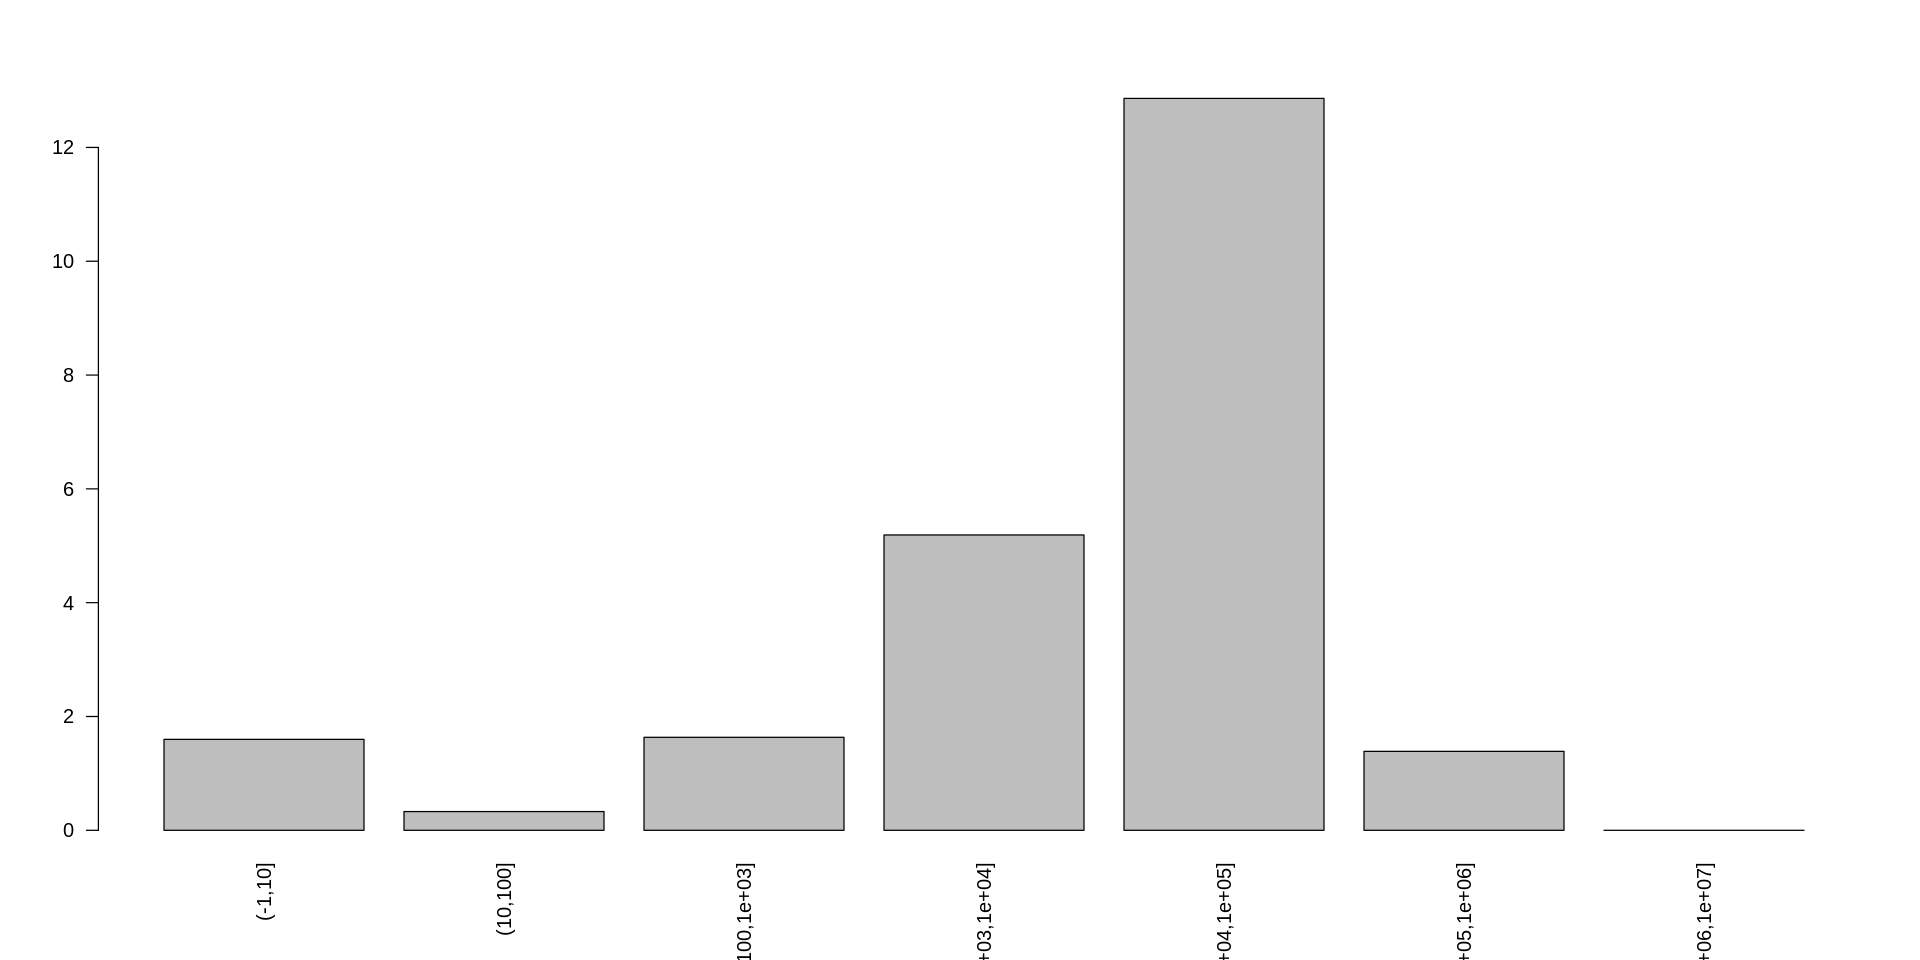

In [26]:
#calculate the average number of genes in each bin
null_bin_means <- data.frame(colMeans(interval_data))
colnames(null_bin_means) <- c("Average")
barplot(height = null_bin_means$Average, names = rownames(null_bin_means), las = 2)

In [27]:
DEGs_binned <- table(cut(min_distance_DEGs$distance, breaks = breaks_seq))
binned_data_all_edges <- cbind(null_bin_means, DEGs = data.frame(DEGs_binned)$Freq)
binned_data_all_edges$Intervals <- rownames(binned_data_all_edges)
binned_data_all_edges

,Average,DEGs,Intervals
,<dbl>,<int>,<chr>
"(-1,10]",1.598,5,"(-1,10]"
"(10,100]",0.329,0,"(10,100]"
"(100,1e+03]",1.634,0,"(100,1e+03]"
"(1e+03,1e+04]",5.190,3,"(1e+03,1e+04]"
"(1e+04,1e+05]",12.862,14,"(1e+04,1e+05]"
"(1e+05,1e+06]",1.387,1,"(1e+05,1e+06]"
"(1e+06,1e+07]",0.000,0,"(1e+06,1e+07]"


In [28]:
binned_data_all_edges_chi2 <- binned_data_all_edges[-nrow(binned_data_all_edges),]
binned_data_all_edges_chi2$Proportion <- binned_data_all_edges_chi2$Average/sum(binned_data_all_edges_chi2$Average)
binned_data_all_edges_chi2

test <- chisq.test(binned_data_all_edges_chi2$DEGs, p = binned_data_all_edges_chi2$Proportion, simulate.p.value = T)
print(test)
test$expected

,Average,DEGs,Intervals,Proportion
,<dbl>,<int>,<chr>,<dbl>
"(-1,10]",1.598,5,"(-1,10]",0.06947826
"(10,100]",0.329,0,"(10,100]",0.01430435
"(100,1e+03]",1.634,0,"(100,1e+03]",0.07104348
"(1e+03,1e+04]",5.190,3,"(1e+03,1e+04]",0.22565217
"(1e+04,1e+05]",12.862,14,"(1e+04,1e+05]",0.55921739
"(1e+05,1e+06]",1.387,1,"(1e+05,1e+06]",0.06030435



	Chi-squared test for given probabilities with simulated p-value (based
	on 2000 replicates)

data:  binned_data_all_edges_chi2$DEGs
X-squared = 10.338, df = NA, p-value = 0.07896



[1]  1.598  0.329  1.634  5.190 12.862  1.387

In [29]:
binned_data_all_edges_chi2
test <- fisher.test(binned_data_all_edges_chi2[,c("Average", "DEGs")])
test

,Average,DEGs,Intervals,Proportion
,<dbl>,<int>,<chr>,<dbl>
"(-1,10]",1.598,5,"(-1,10]",0.06947826
"(10,100]",0.329,0,"(10,100]",0.01430435
"(100,1e+03]",1.634,0,"(100,1e+03]",0.07104348
"(1e+03,1e+04]",5.190,3,"(1e+03,1e+04]",0.22565217
"(1e+04,1e+05]",12.862,14,"(1e+04,1e+05]",0.55921739
"(1e+05,1e+06]",1.387,1,"(1e+05,1e+06]",0.06030435


Warning message in fisher.test(binned_data_all_edges_chi2[, c("Average", "DEGs")]):
“'x' has been rounded to integer: Mean relative difference: 0.07878261”



	Fisher's Exact Test for Count Data

data:  binned_data_all_edges_chi2[, c("Average", "DEGs")]
p-value = 0.5133
alternative hypothesis: two.sided


In [30]:
data_edges <- melt(binned_data_all_edges, id.vars = "Intervals")
data_edges$variable <- ifelse(data_edges$variable == "Average", yes = "Expected", no = "DEGs")
dim(data_edges)
head(data_edges)
unique(data_edges$variable)

[1] 14  3

,Intervals,variable,value
,<chr>,<chr>,<dbl>
1,"(-1,10]",Expected,1.598
2,"(10,100]",Expected,0.329
3,"(100,1e+03]",Expected,1.634
4,"(1e+03,1e+04]",Expected,5.190
5,"(1e+04,1e+05]",Expected,12.862
6,"(1e+05,1e+06]",Expected,1.387


[1] "Expected" "DEGs"

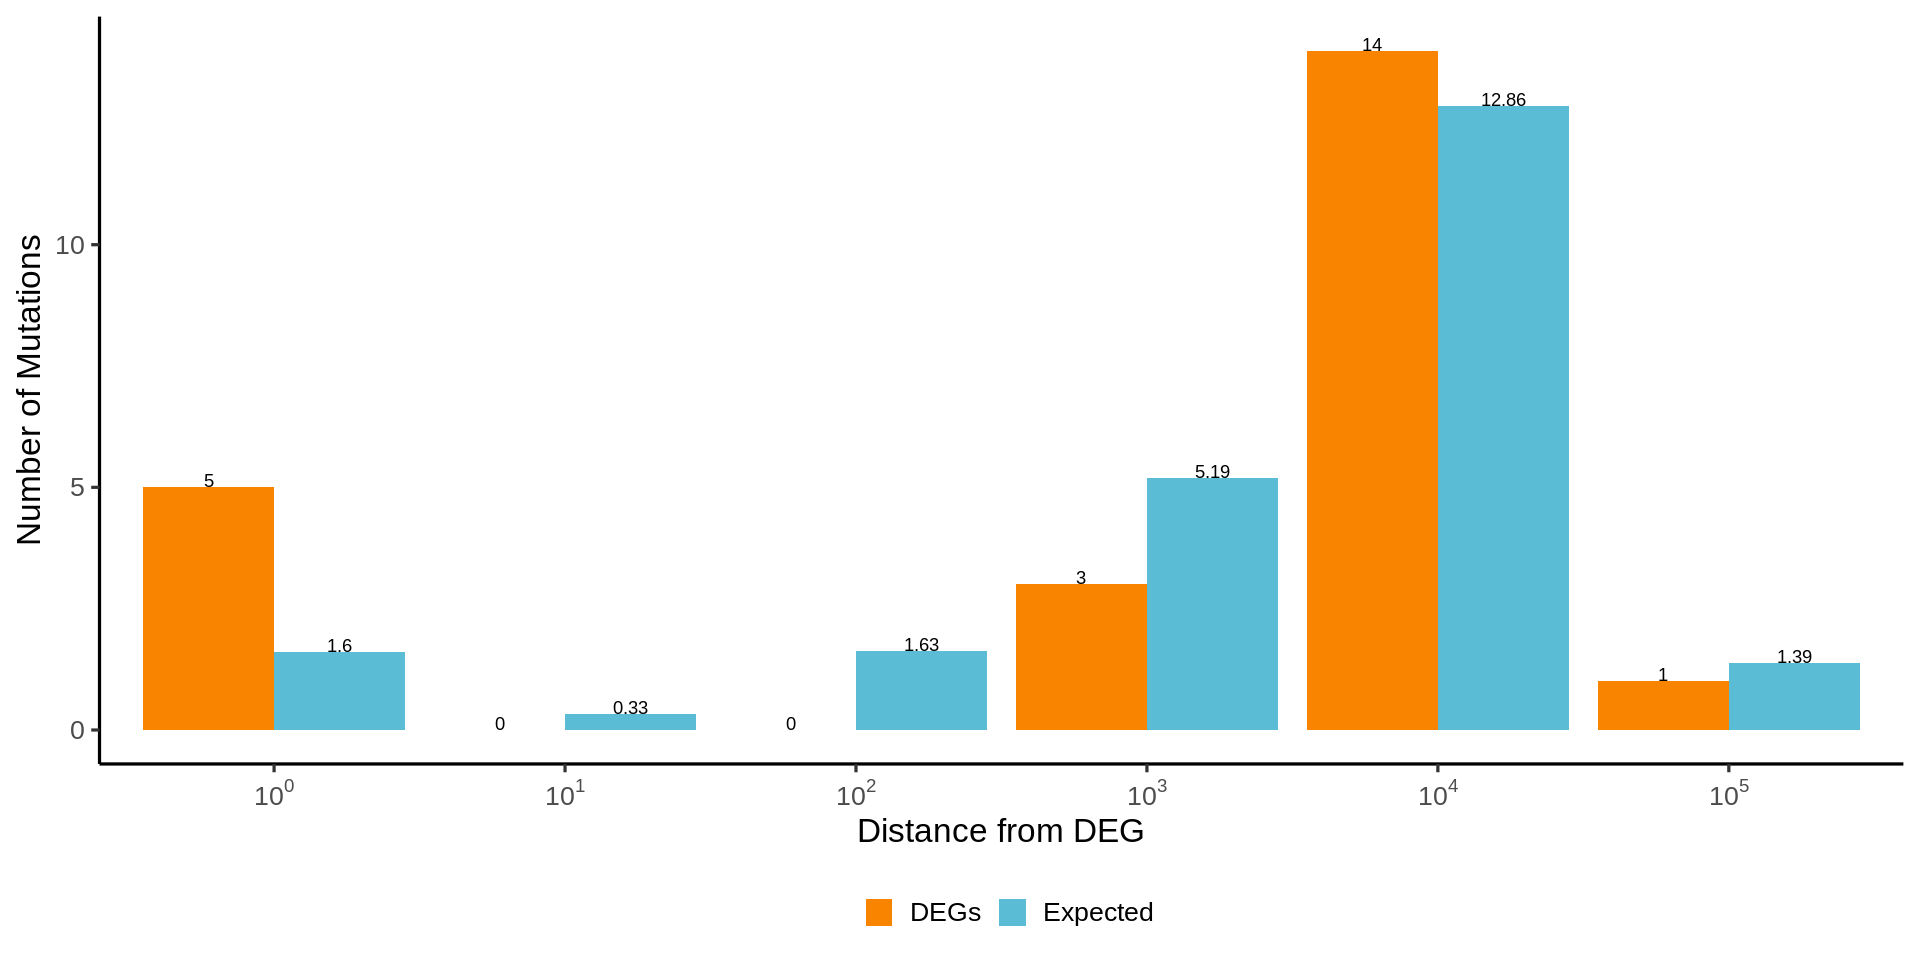

In [31]:
#jpeg(file="Distance_From_DEG.jpeg")
ggplot(data_edges[data_edges$Intervals != "(1e+06,1e+07]",], aes(x=as.factor(Intervals), y=value, fill = variable))+
    geom_bar(stat="identity", position=position_dodge())+ 
    geom_text(vjust = 0, position = position_dodge(0.9), aes(label = round(value, 2)))+
    theme_classic(base_size = 20)+
    scale_fill_manual(values = wes_palette("Darjeeling1", n = 5)[c(4,5)], name= NULL) + 
    xlab("Distance from DEG") +
    ylab("Number of Mutations") +
    scale_x_discrete(labels=c("(-1,10]" = expression("10"^0), "(10,100]" = expression("10"^1),
                              "(100,1e+03]" = expression("10"^2), "(1e+03,1e+04]" = expression("10"^3), "(1e+04,1e+05]" = expression("10"^4), 
                             "(1e+05,1e+06]" = expression("10"^5))) +
    theme(legend.position="bottom")
#dev.off()

## Testing Significance of Mutations in DEGs

In [32]:
rownames(sample_trials) <- sample_trials$mutation_position
sample_trials_cropped <- sample_trials[-c(1,2)]
head(sample_trials_cropped)

,distance,distance2,distance3,distance4,distance5,distance6,distance7,distance8,distance9,distance10,⋯,distance991,distance992,distance993,distance994,distance995,distance996,distance997,distance998,distance999,distance1000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1002758843,86094,26690,13323,0,43032,64463,22820,62240,34961,33991,⋯,68404,59369,4549,0,30130,22820,0,10521,22820,2230
1007223914,25684,0,23367,9675,2527,9675,0,25427,4252,6194,⋯,2122,58727,25684,2122,2527,2527,6194,16682,32977,16682
2007696095,33760,18248,30,21928,2068,135618,13738,14058,8498,83038,⋯,37320,40799,755,14058,39978,103040,3268,2068,55550,32895
3005280766,36993,54260,12127,8026,21475,29810,64273,42626,12127,12127,⋯,5683,4677,4677,7733,5557,4677,21475,5683,42626,12127
5001145933,45078,157156,28785,11573,30753,305,103958,53186,5370,154508,⋯,11573,25816,305,25816,0,30753,48223,45078,151597,217367
5001145934,45077,157155,28786,11572,30752,304,103959,53185,5369,154507,⋯,11572,25817,304,25817,0,30752,48222,45077,151598,217368


In [33]:
#Null
number_0s <- data.frame(in_genes = colSums(sample_trials_cropped == 0))
head(number_0s)
head(min_distance_DEGs)
number_0s_DEGS <- data.frame(in_genes = colSums(min_distance_DEGs[-1] == 0))
number_0s_DEGS

,in_genes
,<dbl>
distance,0
distance2,1
distance3,0
distance4,1
distance5,1
distance6,4


,mutation_position,distance
,<dbl>,<dbl>
1,1002758843,30130
2,1007223914,4252
3,2007696095,13738
4,3005280766,139971
5,5001145933,0
6,5001145934,0


,in_genes
,<dbl>
distance,5


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



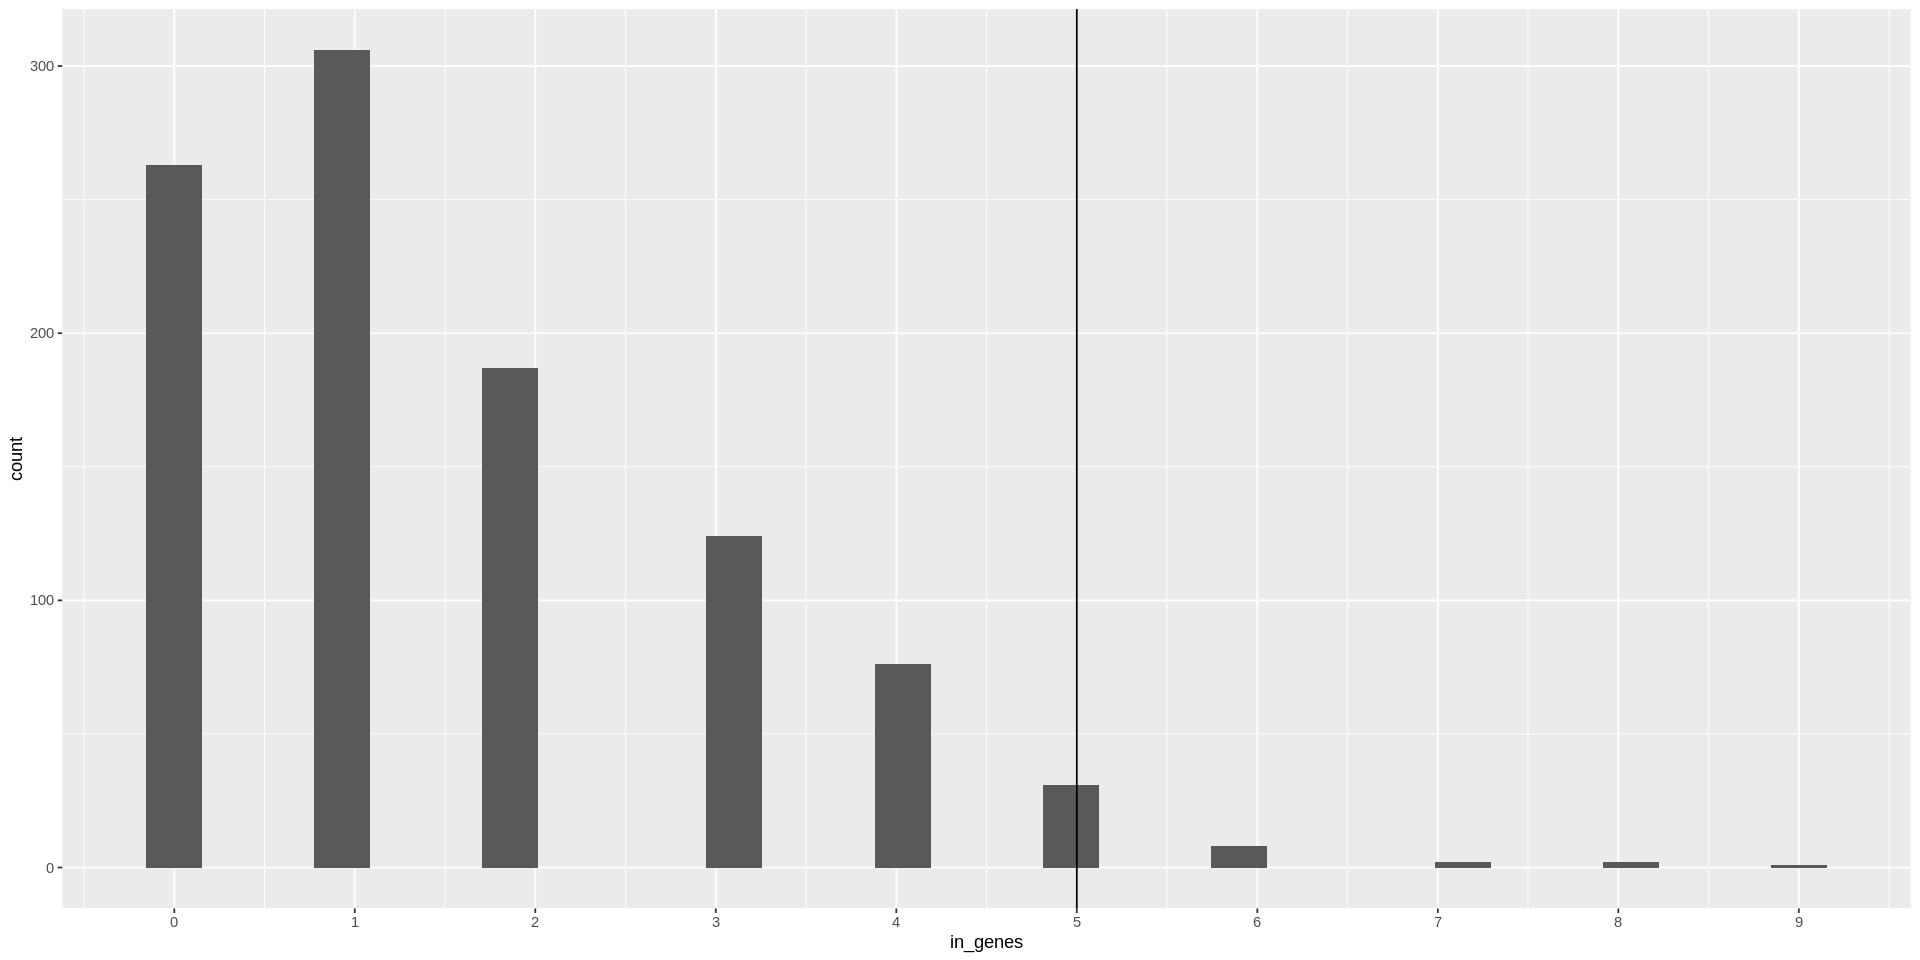

In [34]:
ggplot(data = number_0s, aes(x = in_genes))+
    geom_histogram()+
    geom_vline(xintercept = number_0s_DEGS$in_genes) + 
    scale_x_continuous(breaks = 0:40)

In [35]:
length(number_0s[number_0s$in_genes > number_0s_DEGS$in_genes,])/1000
# dim(number_0s[number_0s$in_genes<35,])

[1] 0.013

In [36]:
beep()